In [1]:
import sleap
import sys
sys.path.append('../')
import analysis.utils.trx_utils as trx_utils

In [2]:
metrics = sleap.load_metrics("../data/models/centered_instance", split="val")
skeleton = sleap.skeleton.Skeleton.load_json("../data/skeleton.json")
px_to_mm = 28.25
# print("\n".join(metrics.keys()))

In [3]:
gt_val = sleap.load_file("../data/models/centered_instance/labels_gt.val.slp")
pr_val = sleap.load_file("../data/models/centered_instance/labels_pr.val.slp")

In [4]:
import pandas as pd
data_index = pd.read_csv("../data/data-index-per-fly.csv").iloc[0:64,:]
index = data_index

In [111]:
from scipy.spatial import distance
def edge_no_edge(labeled_frame, index):
    tmp = labeled_frame.numpy()
    tmp = np.transpose(tmp,(1,2,0))
    tmp = tmp[np.newaxis,:,:,:]
    date_str = labeled_frame.video.backend.filename.split('/')[-2].split('_')[1]
    cams = ['cam1','cam2','cam3','cam4']
    for i in range(len(cams)):
        if cams[i] in labeled_frame.video.backend.filename:
            cam = cams[i]
            break
        else:
            continue
    expmt = date_str + '-lts-' + cam
    expmts_mask = [expmt in d for d in index.File.tolist()]
    expmts = data_index.iloc[np.where(expmts_mask)]
    centers = [np.fromstring(c[1:-1], sep=',') for c in expmts['Center coords (x,y) indexed to UL corner']]

    edge_dist_cutoff = 11*28.25
    edge_list = []
    for fly in range(tmp.shape[3]):
        try:
            thorax = tmp[0,skeleton.node_names.index("thorax"),:,fly][np.newaxis,:]
            dist = distance.cdist(np.array(thorax),centers).min(axis=1)
            if dist < edge_dist_cutoff:
                edge_list.append(False)
            else:
                edge_list.append(True)
        except:
            edge_list.append(False)

    return edge_list
    

In [112]:
import numpy as np
edge_mask = [edge_no_edge(lf, data_index) for lf in gt_val.labeled_frames]
edge_mask = np.array(edge_mask)

In [113]:
gt_instances_edge = []
gt_instances_center = []

pr_instances_edge = []
pr_instances_center = []
for i in range(len(gt_val.labeled_frames)):
    pr_instances_edge.append([pr_val.labeled_frames[i].instances[j] for j in np.where(edge_mask[i,:])[0]])
    pr_instances_center.append([pr_val.labeled_frames[i].instances[j] for j in np.where(~edge_mask[i,:])[0]])

    gt_instances_edge.append([gt_val.labeled_frames[i].instances[j] for j in np.where(edge_mask[i,:])[0]])
    gt_instances_center.append([gt_val.labeled_frames[i].instances[j] for j in np.where(~edge_mask[i,:])[0]])


In [114]:
gt_edge_flat_list = [item for sublist in gt_instances_edge for item in sublist]
pr_edge_flat_list = [item for sublist in pr_instances_edge for item in sublist]

gt_center_flat_list = [item for sublist in gt_instances_center for item in sublist]
pr_center_flat_list = [item for sublist in pr_instances_center for item in sublist]

merged_list_edge = [(gt_edge_flat_list[i], pr_edge_flat_list[i],_) for i in range(0, len(gt_edge_flat_list))]
merged_list_center = [(gt_center_flat_list[i], pr_center_flat_list[i],_) for i in range(0, len(gt_center_flat_list))]


In [115]:
edge = sleap.nn.evals.compute_dists(merged_list_edge)
center = sleap.nn.evals.compute_dists(merged_list_center)

In [116]:
import pandas as pd 
dists = center#metrics['dist.dists']
res = dists * (1/px_to_mm)
res = pd.DataFrame(res, columns = skeleton.node_names)
res = pd.melt(res, value_vars=skeleton.node_names,var_name="Landmark",value_name="Error (mm)")
res_center = res


/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


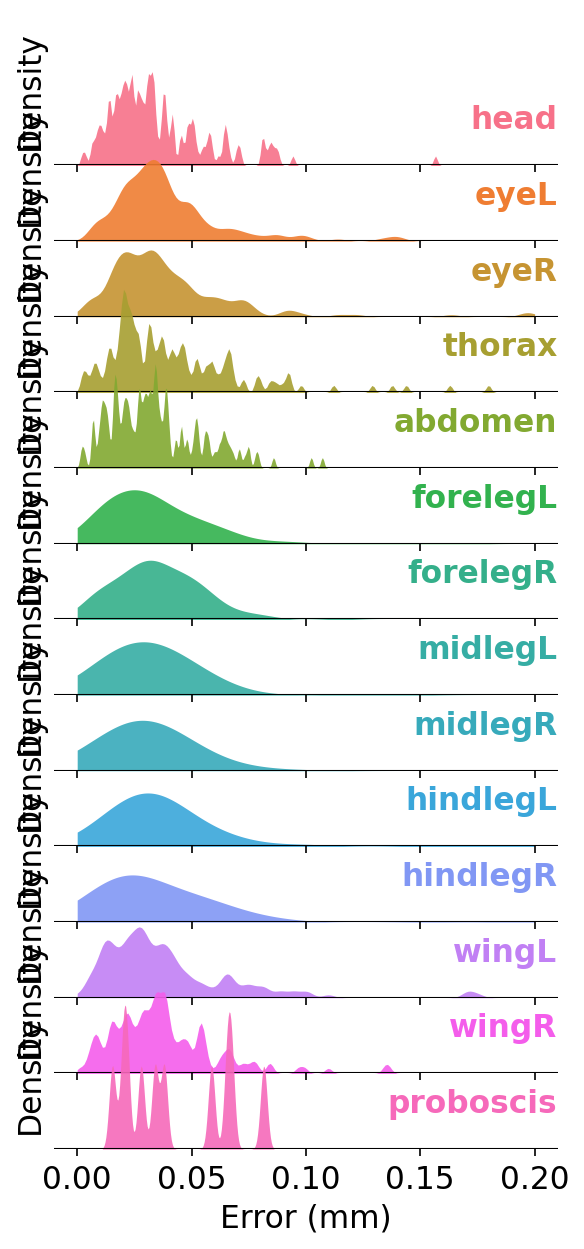

In [117]:

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(res, row="Landmark", hue="Landmark", aspect=7, height=0.6, palette="husl")
g.map(sns.kdeplot, "Error (mm)", bw_adjust=0.1, clip=(0,0.2),fill=True, alpha=0.9, linewidth=0)
g.map(plt.axhline, y=0, lw=1.0, c="k")

def label(x, color, label):
    ax = plt.gca()
    ax.patch.set_alpha(0)
    ax.text(1, 0.3, label, fontweight="bold", color=color, ha="right", va="center", transform=ax.transAxes)
g.map(label, "Landmark")

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.5)
plt.xlabel("Error (mm)");

In [118]:

import pandas as pd 
dists = edge#metrics['dist.dists']
res = dists * (1/px_to_mm)
res = pd.DataFrame(res, columns = skeleton.node_names)
res = pd.melt(res, value_vars=skeleton.node_names,var_name="Landmark",value_name="Error (mm)")
res_edge = res

/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


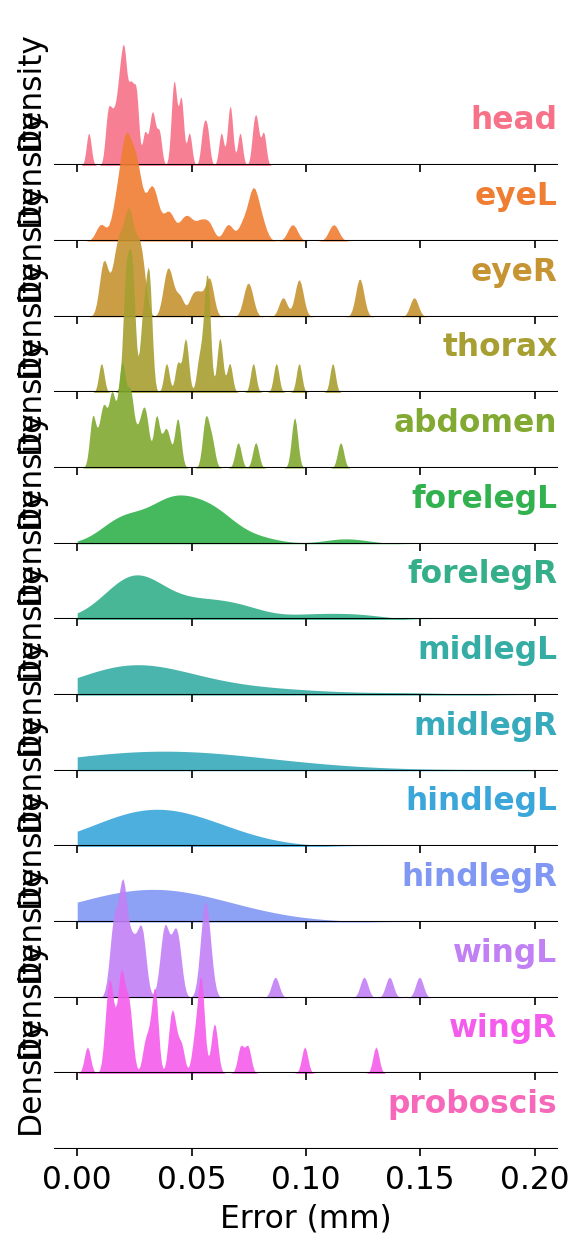

In [119]:

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(res, row="Landmark", hue="Landmark", aspect=7, height=0.6, palette="husl")
g.map(sns.kdeplot, "Error (mm)",clip=(0,.2), bw_adjust=0.1, fill=True, alpha=0.9, linewidth=0)
g.map(plt.axhline, y=0, lw=1.0, c="k")

def label(x, color, label):
    ax = plt.gca()
    ax.patch.set_alpha(0)
    ax.text(1, 0.3, label, fontweight="bold", color=color, ha="right", va="center", transform=ax.transAxes)
g.map(label, "Landmark")

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.5)
plt.xlabel("Error (mm)");

In [120]:
res_edge.to_csv('edge-errors.csv')
res_center.to_csv('center-errors.csv')

In [127]:
res = res_center
errors_90th = res.groupby('Landmark').quantile(.68)
errors_90th_px = errors_90th*28.25

errors_80th = res.groupby('Landmark').quantile(.90)
errors_80th_px = errors_80th*28.25

In [128]:
filename = "../data/cam1_20220217_0through190_cam1_20220217_0through190_1-tracked.analysis.h5"

In [129]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
../data/cam1_20220217_0through190_cam1_20220217_0through190_1-tracked.analysis.h5

===HDF5 datasets===
['instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']

===locations data shape===
(360700, 14, 2, 4)

===nodes===
0: head
1: eyeL
2: eyeR
3: thorax
4: abdomen
5: forelegL
6: forelegR
7: midlegL
8: midlegR
9: hindlegL
10: hindlegR
11: wingL
12: wingR
13: proboscis



In [130]:
import cv2

# pose, img, window, nodes, percs, perc_errs = data["pose"], data["img"], data["window"].squeeze(), data["nodes"], data["percs"], data["perc_errs"]

pose = locations[93932,:,:,0]
videofile = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/organized_videos/20220217-lts-cam1/20220217-lts-cam1-0000.mp4"

cap = cv2.VideoCapture(videofile)
cap.set(1,93932);
success, img = cap.read()


In [131]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style
import matplotlib as mpl
from matplotlib.patches import Circle
from matplotlib import patches

mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = True
mpl.rcParams["font.size"] = 15
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
mpl.rcParams["axes.titlesize"] = "xx-large"  # medium, large, x-large, xx-large

mpl.style.use("seaborn-deep")

/Genomics/argo/users/swwolf/.conda/envs/sleap_dev/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.


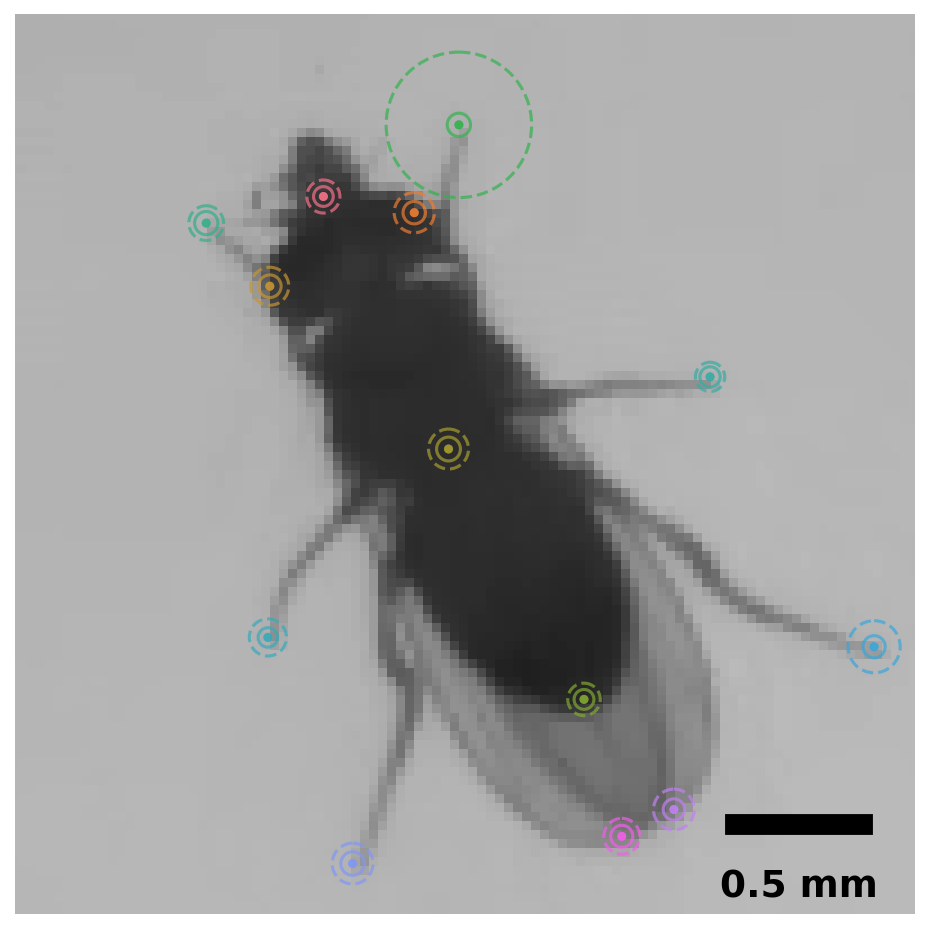

In [132]:
px_per_mm = 28.25
ctr = np.nanmean(pose, axis=0)
window = [-50,50]
nodes = node_names
tmp = [errors_90th_px[errors_90th_px.index == node] for node in node_names]
tmp  = pd.concat(tmp)
perc_errs = tmp.to_numpy()
percs=np.array(["90"])

tmp = [errors_80th_px[errors_80th_px.index == node] for node in node_names]
tmp  = pd.concat(tmp)
perc_errs_80 = tmp.to_numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.autoscale(tight=True)
plt.imshow(img, cmap="gray")
plt.xticks([]), plt.yticks([]);
plt.ylim(window[::-1] + ctr[1])
plt.xlim(window + ctr[0]);



cmap = sns.color_palette("husl", n_colors=len(nodes))
for j in range(len(nodes[:-1])):
    ax.add_patch(Circle(xy=pose[j], radius=.5, fill=True, lw=0, alpha=0.7, fc=cmap[j]))
    ax.add_patch(Circle(xy=pose[j], radius=perc_errs[j], fill=False, lw=1.5, alpha=0.7, ec=cmap[j], label=f"{percs[j]}%" if j == 0 else None))

for j in range(len(nodes[:-1])):
    ax.add_patch(Circle(xy=pose[j], radius=.5, fill=True, lw=0, alpha=0.7, fc=cmap[j]))
    ax.add_patch(Circle(xy=pose[j], radius=perc_errs_80[j], fill=False, lw=1.5, alpha=0.7, ec=cmap[j], label=f"{percs[j]}%" if j == 0 else None,linestyle='dashed'))
    
    
x, y = ctr[0] + 30, ctr[1] + 40
plt.plot([x, x + px_per_mm * 0.5], [y, y], "w-", color="black", lw=10)
plt.text(x + px_per_mm * 0.25, y + 5, "0.5 mm", fontweight="bold", color="black", ha="center", va="top", fontsize=18);


In [95]:
errors_90th

,Error (mm)
Landmark,
abdomen,0.038784
eyeL,0.059854
eyeR,0.052537
forelegL,0.057610
forelegR,0.062419
head,0.045481
hindlegL,0.046591
hindlegR,0.051566
midlegL,0.064088


In [96]:
import sys
sys.path.append('../')
import analysis.utils.trx_utils as trx_utils

In [97]:
import importlib
importlib.reload(trx_utils)
filtered_locations = trx_utils.fill_missing_np(locations)
filtered_locations = trx_utils.smooth_median(filtered_locations)
filtered_locations = trx_utils.smooth_gaussian(filtered_locations)


100%|██████████| 112/112 [00:02<00:00, 52.32it/s]


KeyboardInterrupt: 

In [ ]:
# start = int(2058*99.96)
start = int(2091*99.96)
end = start + 150
trx_utils.plot_trx(filtered_locations, videofile,frame_start=start,frame_end=end,trail_length=100)

Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 61
Frame 62
Frame 63
Frame 64
Frame 65
Frame 66
Frame 67
Frame 68
Frame 69
Frame 70
Frame 71
Frame 72
Frame 73
Frame 74
Frame 75
Frame 76
Frame 77
Frame 78
Frame 79
Frame 80
Frame 81
Frame 82
Frame 83
Frame 84
Frame 85
Frame 86
Frame 87
Frame 88
Frame 89
Frame 90
Frame 91
Frame 92
Frame 93
Frame 94
Frame 95
Frame 96
Frame 97
Frame 98
Frame 99
Frame 100
Frame 101
Frame 102
Frame 103
Frame 104
Frame 105
Frame 106
Frame 107
Frame 108
Frame 109
Frame 110
